In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import mplfinance as mplf
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier

import bars
import c
import signals
import u

# Data Generation

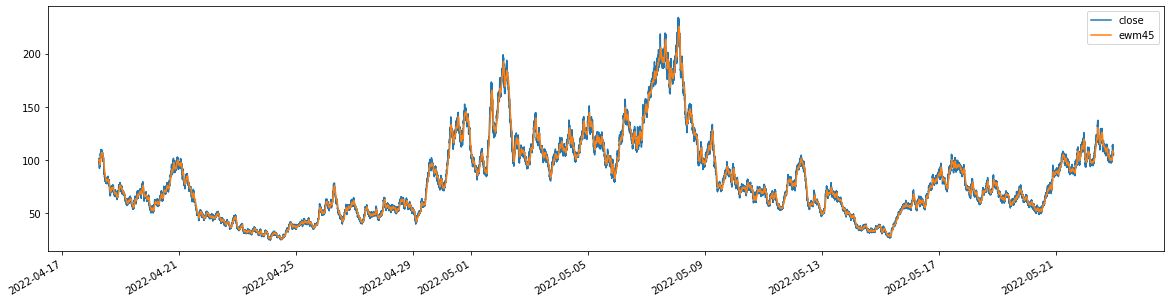

In [3]:
plt.rcParams["figure.figsize"] = (20, 5)

data = u.create_price_data(theta=0.0001, start_price=100, n_samples=50000)
data["ewm45"] = data["close"].ewm(span=45).mean()
data["close"].plot.line()
data["ewm45"].plot.line()
plt.legend()

## Zoom in of Price

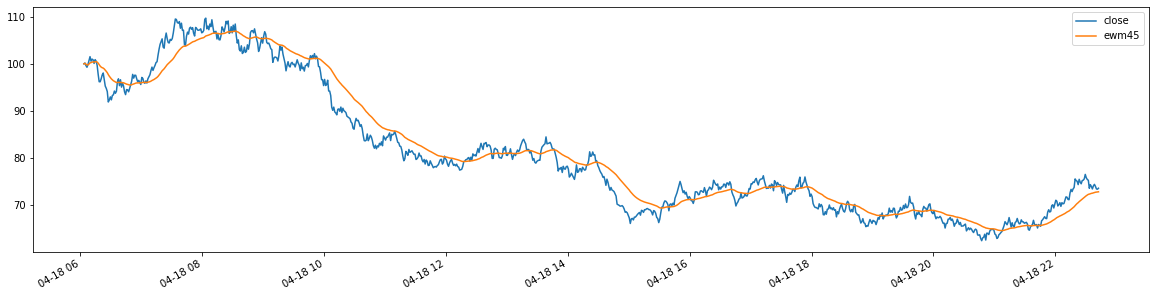

In [4]:
data.iloc[:1000,]["close"].plot.line()
data.iloc[:1000,]["ewm45"].plot.line()
plt.legend()

In [5]:
ewm45 = data["ewm45"]
curr = data["close"]
prev = data["close"].shift(1)
cross_up = ((curr > ewm45) & (prev < ewm45))
cross_down = ((curr < ewm45) & (prev > ewm45))
data["dir"] = cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
data["trade"] = cross_up | cross_down
data.head(10)

,close,ewm45,dir,trade
2022-04-18 06:03:27.409487,100.00,100.000000,0,False
2022-04-18 06:04:27.409487,100.18,100.092000,1,True
2022-04-18 06:05:27.409487,99.62,99.927623,-1,True
2022-04-18 06:06:27.409487,99.27,99.752098,0,False
2022-04-18 06:07:27.409487,99.89,99.782184,1,True
2022-04-18 06:08:27.409487,100.67,99.947070,1,True
2022-04-18 06:09:27.409487,101.52,100.202818,0,False
2022-04-18 06:10:27.409487,100.56,100.254712,0,False
2022-04-18 06:11:27.409487,101.00,100.352987,0,False
2022-04-18 06:12:27.409487,100.85,100.413203,0,False


# Triple Barrier

In [6]:
resampled = data.resample("H")
target = np.mean((resampled["close"].last() / resampled["close"].first()).std()) * 0.5
price_target = 1
stop_loss = 1
vertical_barrier = np.timedelta64(1, "h")

target

0.038636833894246984

In [7]:
indices = data.loc[data["trade"]].index

diff = np.timedelta64(30, "m")
last = indices[0]
new_indices = [last]
for i in indices:
    if last + diff < i:
        new_indices.append(i)
        last = i

indices = new_indices

barriers = signals.get_price_target_stop_loss_indices(
    data, indices, target=target, side=data.loc[indices, "dir"], price_target=price_target, stop_loss=stop_loss, vertical_barrier=vertical_barrier
)
barriers = signals.add_profit_target_stop_loss_outcome(barriers)
barriers.head()

,pt_dt,sl_dt,side,pt_sl,pt
2022-04-18 06:04:27.409487,NaT,2022-04-18 06:18:27.409487,1,-1,False
2022-04-18 06:36:27.409487,2022-04-18 07:14:27.409487,NaT,1,1,True
2022-04-18 08:14:27.409487,2022-04-18 09:09:27.409487,NaT,-1,1,True
2022-04-18 08:47:27.409487,NaT,2022-04-18 09:09:27.409487,1,-1,False
2022-04-18 09:46:27.409487,NaT,2022-04-18 09:57:27.409487,1,-1,False


In [8]:
last = barriers.index[0]
plot_indices = [last]
for i in barriers.index:
    if last + vertical_barrier < i:
        plot_indices.append(i)
        last = i

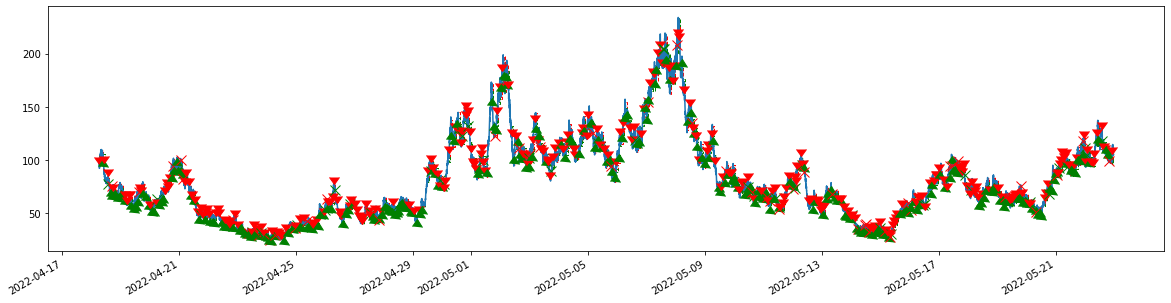

In [9]:
import plt_utils

fig, ax = plt.subplots()
data["close"].plot.line()

plt_utils.plot_triple_barrier(
    ax,
    data,
    barriers.loc[plot_indices],
    target=target,
    price_target=price_target,
    stop_loss=stop_loss,
    vertical_barrier=vertical_barrier,
)

# Classifier

In [10]:
train = barriers.merge(data, how='left', left_index=True, right_index=True)
train.head()

,pt_dt,sl_dt,side,pt_sl,pt,close,ewm45,dir,trade
2022-04-18 06:04:27.409487,NaT,2022-04-18 06:18:27.409487,1,-1,False,100.18,100.092000,1,True
2022-04-18 06:36:27.409487,2022-04-18 07:14:27.409487,NaT,1,1,True,96.18,96.033867,1,True
2022-04-18 08:14:27.409487,2022-04-18 09:09:27.409487,NaT,-1,1,True,105.27,106.463410,-1,True
2022-04-18 08:47:27.409487,NaT,2022-04-18 09:09:27.409487,1,-1,False,106.64,105.393733,1,True
2022-04-18 09:46:27.409487,NaT,2022-04-18 09:57:27.409487,1,-1,False,101.71,101.061687,1,True


In [11]:
model = RandomForestClassifier(n_estimators=100, max_depth=20)
cols = ["close", "ewm45"]
model.fit(train[cols], train["pt"])

RandomForestClassifier(max_depth=10)

## Test

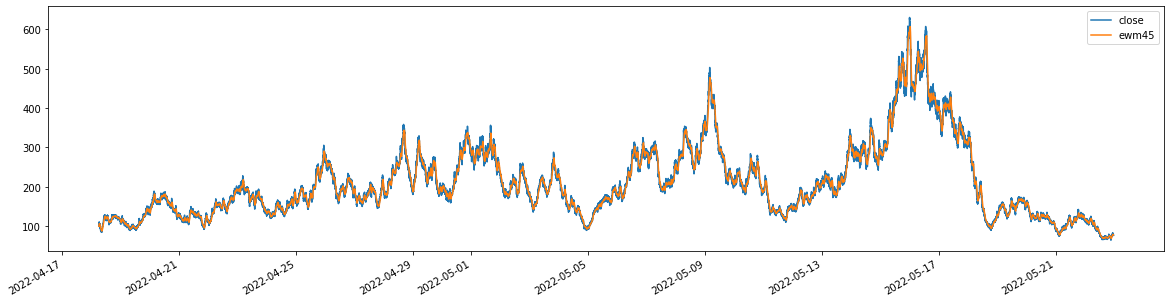

In [12]:
test = u.create_price_data(theta=0.0001, start_price=100, n_samples=50000)
test["ewm45"] = test["close"].ewm(span=45).mean()
ewm45 = test["ewm45"]
curr = test["close"]
prev = test["close"].shift(1)
cross_up = ((curr > ewm45) & (prev < ewm45))
cross_down = ((curr < ewm45) & (prev > ewm45))
test["dir"] = cross_up * c.Dir.B + cross_down * c.Dir.S + (~(cross_up | cross_down)) * c.Dir.U
test["trade"] = cross_up | cross_down
test["close"].plot.line()
test["ewm45"].plot.line()
plt.legend()

In [13]:
pred = test.loc[test["trade"] == True].index

diff = np.timedelta64(5, "m")
last = pred[0]
new_indices = [last]
for i in pred:
    if last + diff < i:
        new_indices.append(i)
        last = i

pred = new_indices
pred = signals.get_price_target_stop_loss_indices(
    test, pred, target=target, side=test.loc[pred, "dir"], price_target=price_target, stop_loss=stop_loss, vertical_barrier=vertical_barrier
)
pred = signals.add_profit_target_stop_loss_outcome(pred)
pred["pred"] = model.predict(test.loc[pred.index][cols])

pred.head()

,pt_dt,sl_dt,side,pt_sl,pt,pred
2022-04-18 06:04:34.569675,2022-04-18 06:10:34.569675,2022-04-18 07:00:34.569675,1,1,True,False
2022-04-18 06:22:34.569675,2022-04-18 06:32:34.569675,NaT,-1,1,True,False
2022-04-18 06:28:34.569675,NaT,2022-04-18 06:31:34.569675,1,-1,False,False
2022-04-18 06:41:34.569675,NaT,2022-04-18 06:55:34.569675,1,-1,False,False
2022-04-18 06:49:34.569675,2022-04-18 06:56:34.569675,NaT,-1,1,True,False


In [14]:
info = pred.merge(test, how='left', left_index=True, right_index=True)
info.loc[info["pred"] == True].head()

,pt_dt,sl_dt,side,pt_sl,pt,pred,close,ewm45,dir,trade
2022-04-18 11:51:34.569675,NaT,2022-04-18 11:55:34.569675,1,-1,False,True,121.92,121.500065,1,True
2022-04-18 12:10:34.569675,2022-04-18 12:39:34.569675,NaT,1,1,True,True,119.08,118.878230,1,True
2022-04-18 14:28:34.569675,2022-04-18 15:15:34.569675,NaT,1,1,True,True,111.31,110.453268,1,True
2022-04-18 14:43:34.569675,NaT,2022-04-18 15:15:34.569675,-1,-1,False,True,111.44,111.488970,-1,True
2022-04-18 15:03:34.569675,2022-04-18 15:10:34.569675,NaT,1,1,True,True,110.53,110.458334,1,True


<AxesSubplot:>

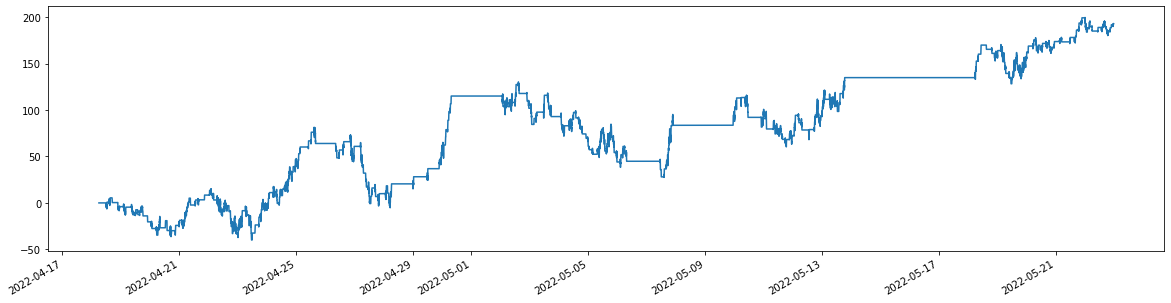

In [15]:
u_pnl = np.zeros(len(test.index))
r_pnl = np.zeros(len(test.index))
entry = None
pred_ = None
trades = 0
for e, (i, r) in enumerate(test.iterrows()):
    if entry is not None:
        if i == pred_["pt_dt"] or i == pred_["sl_dt"] or i > pred_.name + vertical_barrier:
            r_pnl[e] += (r["close"] - entry["close"]) * entry["dir"]
            entry = None
            pred_ = None
        else:
            u_pnl[e] = (r["close"] - entry["close"]) * entry["dir"]
    elif entry is None and r["trade"] and i in pred.index and pred.loc[i, "pred"]:
        entry = i
        entry = r
        pred_ = pred.loc[i]
        trades += 1

r_pnl = r_pnl.cumsum()
test["pnl"] = u_pnl + r_pnl
test["pnl"].plot.line()